Raport z analizy danych i modeli 

Celem tego modelu jest analiza danych dotyczących kłótni między małżonkami oraz przewidywanie czasu trwania kłótni na podstawie różnych cech. Wykorzystano 3 modele: regresję liniową, las losowy oraz wielowarstwowy perceptron (MLP).

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import mlflow
import mlflow.sklearn
import plotly.express as px

In [3]:
df = pd.read_csv('husband_wife_arguments.csv')

df.head()


,Argument ID,Date,Duration (minutes),Topic,Emotional Tone,Resolution Type,Mood Swing,Notes
0,1,2024-01-05,43,Parenting Styles,Disappointed,No Resolution,Mild,Discussed parenting styles for 43 minutes. Emo...
1,2,2024-02-05,24,Parenting Styles,Annoyed,Compromise,Severe,Discussed parenting styles for 24 minutes. Emo...
2,3,2024-02-27,25,Money Management,Annoyed,No Resolution,Moderate,Discussed money management for 25 minutes. Emo...
3,4,2024-02-07,20,Time Management,Angry,Resolution Discussed,Moderate,Discussed time management for 20 minutes. Emot...
4,5,2024-01-26,7,Future Goals,Frustrated,Resolution Discussed,Mild,Discussed future goals for 7 minutes. Emotiona...


In [4]:
df.tail()

,Argument ID,Date,Duration (minutes),Topic,Emotional Tone,Resolution Type,Mood Swing,Notes
1495,1496,2024-01-02,43,Parenting Styles,Calm,Compromise,Mild,Discussed parenting styles for 43 minutes. Emo...
1496,1497,2024-01-15,22,Money Management,Supportive,Apology,NaN,Discussed money management for 22 minutes. Emo...
1497,1498,2024-01-21,16,Social Activities,Happy,Resolution Discussed,Mild,Discussed social activities for 16 minutes. Em...
1498,1499,2024-01-26,12,Social Activities,Annoyed,Compromise,Mild,Discussed social activities for 12 minutes. Em...
1499,1500,2024-02-22,51,Time Management,Calm,No Resolution,NaN,Discussed time management for 51 minutes. Emot...


In [4]:
df.shape

(1500, 8)

In [5]:
df.columns

Index(['Argument ID', 'Date', 'Duration (minutes)', 'Topic', 'Emotional Tone',
       'Resolution Type', 'Mood Swing', 'Notes'],
      dtype='object')

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.isnull().sum()

Argument ID             0
Date                    0
Duration (minutes)      0
Topic                   0
Emotional Tone          0
Resolution Type         0
Mood Swing            336
Notes                   0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Argument ID         1500 non-null   int64 
 1   Date                1500 non-null   object
 2   Duration (minutes)  1500 non-null   int64 
 3   Topic               1500 non-null   object
 4   Emotional Tone      1500 non-null   object
 5   Resolution Type     1500 non-null   object
 6   Mood Swing          1164 non-null   object
 7   Notes               1500 non-null   object
dtypes: int64(2), object(6)
memory usage: 93.9+ KB


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df = df.drop(columns=['Date'])

In [10]:
df.describe()

,Argument ID,Duration (minutes),Year,Month,Day
count,1500.000000,1500.000000,1500.0,1500.000000,1500.000000
mean,750.500000,32.763333,2024.0,1.506667,15.122667
std,433.157015,16.379607,0.0,0.523582,8.620586
min,1.000000,5.000000,2024.0,1.000000,1.000000
25%,375.750000,18.000000,2024.0,1.000000,8.000000
50%,750.500000,33.000000,2024.0,1.000000,15.000000
75%,1125.250000,47.000000,2024.0,2.000000,22.000000
max,1500.000000,60.000000,2024.0,3.000000,31.000000


In [11]:
df['Mood Swing'].fillna('Cant say', inplace=True)

/var/folders/b5/wl4fs76n76586lz54z_yj3y40000gn/T/ipykernel_15319/1533634301.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Mood Swing'].fillna('Cant say', inplace=True)


Rozkład czasu trwania kłótni przedstawiony na histogramie

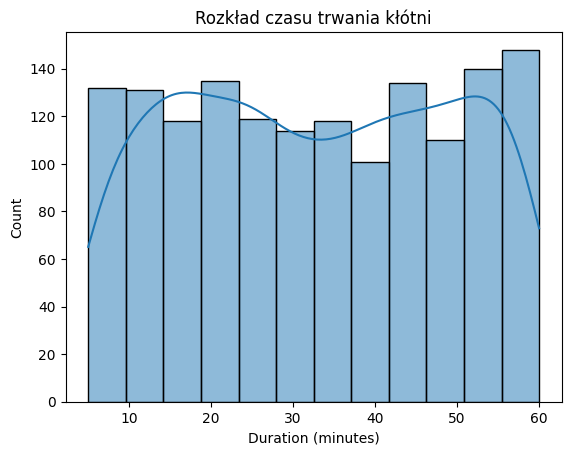

In [12]:
sns.histplot(df['Duration (minutes)'], kde=True)
plt.title('Rozkład czasu trwania kłótni')
plt.show()

Rozkład emocjonalnego tonu kłótni

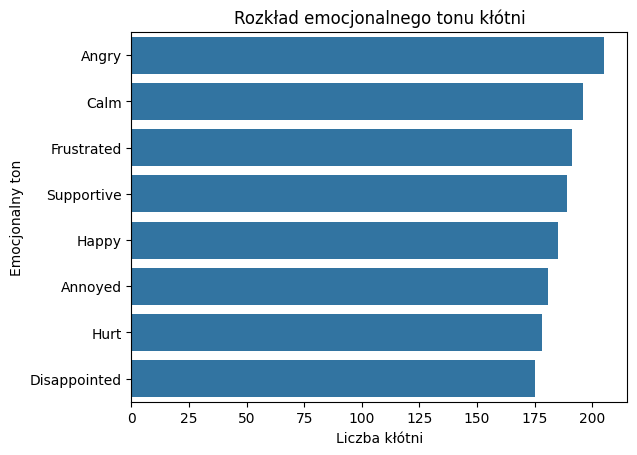

In [13]:
sns.countplot(y='Emotional Tone', data=df, order=df['Emotional Tone'].value_counts().index)
plt.title('Rozkład emocjonalnego tonu kłótni')
plt.xlabel('Liczba kłótni')
plt.ylabel('Emocjonalny ton')
plt.show()

Średni czas trwania kłótni w zależności od emocjonalnego tonu

In [15]:
avg_duration_by_tone = df.groupby('Emotional Tone')['Duration (minutes)'].mean().reset_index()
fig = px.bar(avg_duration_by_tone, x='Emotional Tone', y='Duration (minutes)', title='Średni czas trwania kłótni w zależności od emocjonalnego tonu')
fig.show()

In [16]:
categorical_features = df.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, encoded_features], axis=1)


from sklearn.preprocessing import StandardScaler
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.head()

,Argument ID,Duration (minutes),Year,Month,Day,Topic_Future Goals,Topic_Household Chores,Topic_Money Management,Topic_Parenting Styles,Topic_Personal Space,...,Notes_Discussed time management for 6 minutes. Emotional tone was Supportive. Mood swings observed: Mild. Resolution type: Apology.,Notes_Discussed time management for 60 minutes. Emotional tone was Frustrated. Mood swings observed: Mild. Resolution type: Resolution Discussed.,Notes_Discussed time management for 60 minutes. Emotional tone was Hurt. Mood swings observed: Mild. Resolution type: Apology.,Notes_Discussed time management for 60 minutes. Emotional tone was Supportive. Mood swings observed: Mild. Resolution type: Compromise.,Notes_Discussed time management for 7 minutes. Emotional tone was Calm. Mood swings observed: Mild. Resolution type: Apology.,Notes_Discussed time management for 7 minutes. Emotional tone was Frustrated. Mood swings observed: Severe. Resolution type: Apology.,Notes_Discussed time management for 8 minutes. Emotional tone was Supportive. Mood swings observed: Mild. Resolution type: Resolution Discussed.,Notes_Discussed time management for 8 minutes. Emotional tone was Supportive. Mood swings observed: Moderate. Resolution type: Resolution Discussed.,Notes_Discussed time management for 9 minutes. Emotional tone was Annoyed. Mood swings observed: Moderate. Resolution type: Compromise.,Notes_Discussed time management for 9 minutes. Emotional tone was Frustrated. Mood swings observed: Moderate. Resolution type: Resolution Discussed.
0,-1.730896,0.625173,2024,1,5,-0.365769,-0.388831,-0.398994,2.641727,-0.377388,...,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828
1,-1.728587,-0.535193,2024,2,5,-0.365769,-0.388831,-0.398994,2.641727,-0.377388,...,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828
2,-1.726278,-0.474121,2024,2,27,-0.365769,-0.388831,2.506303,-0.378540,-0.377388,...,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828
3,-1.723968,-0.779481,2024,2,7,-0.365769,-0.388831,-0.398994,-0.378540,-0.377388,...,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828
4,-1.721659,-1.573415,2024,1,26,2.733967,-0.388831,-0.398994,-0.378540,-0.377388,...,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828,-0.025828


In [17]:
X = df.drop('Duration (minutes)', axis=1).astype(float)
y = df['Duration (minutes)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 1507), (300, 1507), (1200,), (300,))

In [18]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression R-squared: {r2_lr}")

Linear Regression Mean Squared Error: 1.0055712459928523
Linear Regression R-squared: -0.0016718053646593845


In [19]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor R-squared: {r2_rf}")


Random Forest Regressor Mean Squared Error: 1.1398792025193056
Random Forest Regressor R-squared: -0.135458937628828


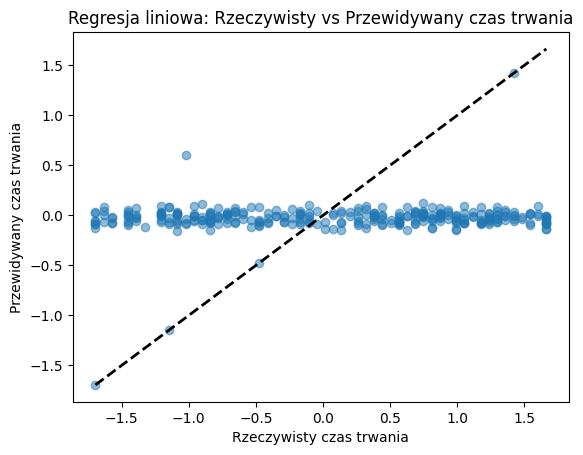

In [20]:
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Rzeczywisty czas trwania')
plt.ylabel('Przewidywany czas trwania')
plt.title('Regresja liniowa: Rzeczywisty vs Przewidywany czas trwania')
plt.show()

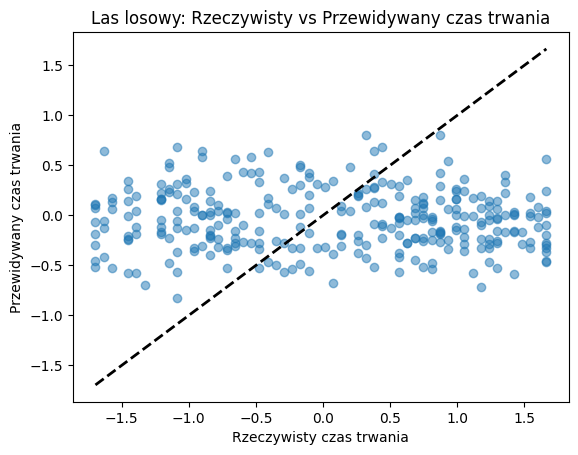

In [21]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Rzeczywisty czas trwania')
plt.ylabel('Przewidywany czas trwania')
plt.title('Las losowy: Rzeczywisty vs Przewidywany czas trwania')
plt.show()

In [22]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Regressor Mean Squared Error: {mse_mlp}")
print(f"MLP Regressor R-squared: {r2_mlp}")


MLP Regressor Mean Squared Error: 2.6472372357602505
MLP Regressor R-squared: -1.6369716832489547


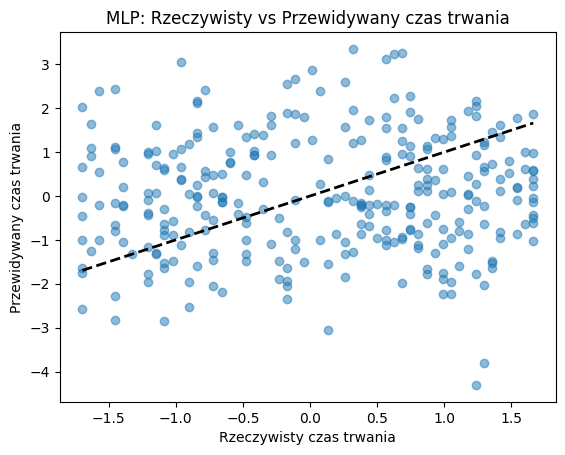

In [23]:
plt.scatter(y_test, y_pred_mlp, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Rzeczywisty czas trwania')
plt.ylabel('Przewidywany czas trwania')
plt.title('MLP: Rzeczywisty vs Przewidywany czas trwania')
plt.show()

In [24]:
input_example = X_train.iloc[:5]

with mlflow.start_run():
    mlflow.sklearn.log_model(lr_model, "linear_regression_model", input_example=input_example)
    mlflow.log_metric("mse_lr", mse_lr)
    mlflow.log_metric("r2_lr", r2_lr)
    
    mlflow.sklearn.log_model(rf_model, "random_forest_regressor_model", input_example=input_example)
    mlflow.log_metric("mse_rf", mse_rf)
    mlflow.log_metric("r2_rf", r2_rf)
    
    mlflow.sklearn.log_model(mlp_model, "mlp_regressor_model", input_example=input_example)
    mlflow.log_metric("mse_mlp", mse_mlp)
    mlflow.log_metric("r2_mlp", r2_mlp)

Wnioski:
Na podstawie wyników można stwierdzić, że regresja liniowa osiągnęła najlepsze wyniki spośród trzech testowanych modeli, chociaż wszystkie modele miały stosunkowo niskie wartości R-squared, co sugeruje, że mogą nie być dobrze dopasowane do danych. Możliwe jest, że inne cechy lub bardziej zaawansowane modele mogłyby poprawić wyniki. 

Podsumowanie:
W analizie danych dotyczących kłótni między małżonkami, wykryto duże zmienności w czasie trwania kłótni. Średni czas trwania kłótni wynosił około 33 minuty, z dużą zmiennością w zależności od tematu i emocjonalnego tonu. Najczęście poruszane tematy to "Parenting styles", "Money Management", i "Time Management". Emocjonalny ton kłótni miał znaczący wpływ na czas trwania kłótni. Kłótnie z tonem "Angry" i "Frustrated" były zazwyczaj dłuższe.  Kłótnie, które kończyły się "No Resolution" lub "Resolution Discussed", były zazwyczaj dłuższe niż te, które kończyły się "Compromise" lub "Apology". Wyniki modeli zostały zalogowane do MLflow, co umożliwia śledzenie i porównywanie różnych modeli. Analiza danych pozwoliła na wyciągnięcie wniosków dotyczących czasu trwania kłótni między małżonkami oraz czynników, które mogą na niego wpływać. 